In [1]:
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

length and shape of car dataset: 6108 (64, 64, 3)
length and shape of notcar dataset: 8968 (64, 64, 3)


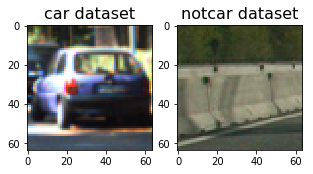

In [2]:
### Data Processing

# Importing images
cars = []
notcars = []
n = 20
# Add non car images
images = glob.glob('./non-vehicles/**/*.png', recursive=True)
for image in images:
    notcars.append(image)
# Add car images from KITTI
images_KITTI = glob.glob('./vehicles/KITTI_extracted/*.png')
for image in images_KITTI:
    cars.append(image)
# Add every nth car image from GTI to reduce overfitting in classifier (due to many similar images)
images_GTI = glob.glob('./vehicles/GTI/**/*.png', recursive=True)
for i in range(0, len(images_GTI), n):
    cars.append(images_GTI[i])


rand_int = np.random.randint(0, len(cars))
image = cv2.imread(cars[rand_int])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rand_int2 = np.random.randint(0, len(notcars))
image2 = cv2.imread(notcars[rand_int2])
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display image shape
print('length and shape of car dataset:', len(cars), image.shape)
print('length and shape of notcar dataset:', len(notcars), image2.shape)

# Visualize the results
fig = plt.figure(figsize=(8, 2))
image_list = [[image, 'car dataset'],
              [image2, 'notcar dataset']]
rows = 1
cols = 4
for i in range(len(image_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(image_list[i][0])
    ax.set_title(image_list[i][1], fontsize=16)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

In [3]:
### Functions

# Convert a RGB image to new color 
def convert_color(img, conv):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img


# Color Histogram
def color_hist(img, nbins):
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return hist_features


# Spatial Binning of Color
def bin_spatial(img, size):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Histogram of Oriented Gradients (HOG)
def get_hog_features(img, orient, pix_per_cell, cells_per_block, vis, feature_vec):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block), 
                                  transform_sqrt=False, visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), 
                       transform_sqrt=False, visualise=vis,
                       feature_vector=feature_vec)
        return features

    
# Extract features from a list of images
def extract_features(imgs, color_space, spatial_size, hist_bins, orient, pix_per_cell,
                     cells_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply color conversion
        feature_image = convert_color(image, conv=color_space)

        # Get features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cells_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cells_per_block,
                                                vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins, color_space, vis=False):
    
    draw_img = np.copy(img)
    window_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)

    # Loop through the different image sizes
    for scale in scale_list:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    window_list.append(box)
                    # Draw rectangle on image
                    if vis == 1:
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6)

    if vis == 1:
        return window_list, draw_img
    else:
        return window_list


# Add 'heat' to each detected car pixel
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    hmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    hmap[hmap <= threshold] = 0
    # Return thresholded map
    return hmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [4]:
### Parameters

# Load pickled data
with open('./classifier.p', mode='rb') as f:
    train = pickle.load(f)

svc = train['svc']
X_scaler = train['X_scaler']
color_space = 'YCrCb'      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ystart = 400
ystop = 656
scale_list = np.arange(1.0, 2.1, 0.5)
orient = 9                 # HOG orientations
pix_per_cell = 8           # HOG pixels per cell
cells_per_block = 2        # HOG cells per block
hog_channel = "ALL"        # HOG channels can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)    # Spatial binning dimensions
hist_bins = 32             # Number of histogram bins
hog_feat = True            # HOG features on or off
spatial_feat = True        # Spatial features on or off
hist_feat = True           # Histogram features on or off
threshold = 9              # Threshold for heat map
threshold2 = 5             # Threshold for number of images to stack bounding boxes
heat_list = []
counter = 1

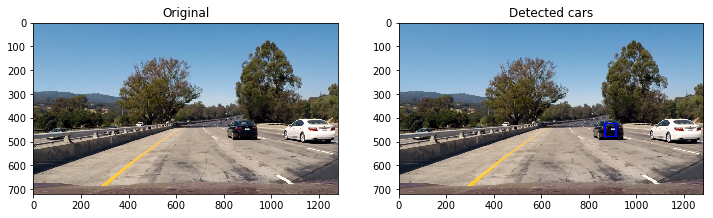

In [5]:
### Main Function

def detect_cars(image):

    box_list = find_cars(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, cells_per_block, spatial_size, hist_bins, color_space)

    if counter == 1:
        # Define a blank image on which to add 'heat'
        global heat
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
    global counter
    counter += 1

    # Add heat to each box in box_list
    heat = add_heat(heat, box_list)
    new_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    new_heat = add_heat(new_heat, box_list)
    heat_list.append(new_heat)

    if counter > threshold2:
        counter = threshold2
        neg_heat = heat_list.pop(0)
        heat -= neg_heat

    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(heat, threshold)

    # Find final boxes from heatmap using label function
    structure = np.ones((3,3))
    labels = label(heat_thresh, structure=structure)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

# Load an image on which to detect cars
image = cv2.imread('./test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
out_img = detect_cars(image)

# Display detected cars
fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original')
plt.subplot(122)
plt.imshow(out_img)
plt.title('Detected cars')

In [ ]:
### Project video

counter = 1
heat_list = []

def process_image(image):
    result = detect_cars(image)
    return result

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./test_video.mp4")
#clip1 = VideoFileClip("./out.mp4")
#clip1 = VideoFileClip("./out2.mp4")
#clip1 = VideoFileClip("./out3.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [34:41<00:01,  1.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2h 1min 5s, sys: 2min 5s, total: 2h 3min 10s
Wall time: 34min 42s


In [ ]:
### Extracting Features for classifier
### Train the classifier

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cells_per_block=cells_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat,
                                hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cells_per_block=cells_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat,
                                   hog_feat=hog_feat)

# Define feature vector
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Free up some memory
del car_features
del notcar_features

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.15, random_state=rand_state)

print('X_train = {}, y_train = {}'.format(len(X_train), len(y_train)))
print('X_test = {}, y_test = {}'.format(len(X_test), len(y_test)))
print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cells_per_block,'cells per block')

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
pred = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', pred)
# Check the prediction time for a single sample
t=time.time()
print(round(t-t2, 2), 'Seconds to test SVC...')

# Create dictionary
dict = {'svc': svc, 'X_scaler': X_scaler}

# Write to pickle file
pickle.dump(dict, open("classifier.p", "wb"))
print('pickle saved...')

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[rand_int])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[rand_int])
plt.title('Normalized Features')
fig.tight_layout()

X_train = 12814, y_train = 12814
X_test = 2262, y_test = 2262
Using: 9 orientations 8 pixels per cell and 2 cells per block


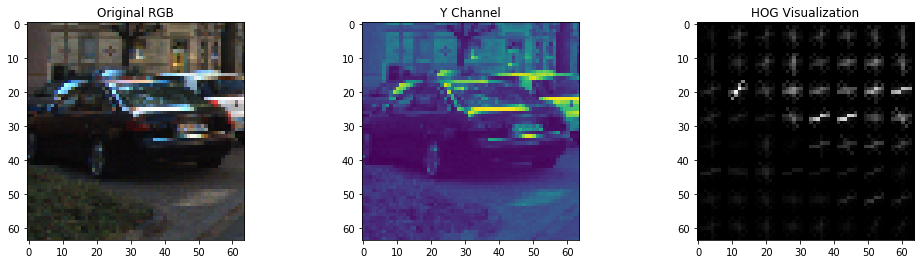

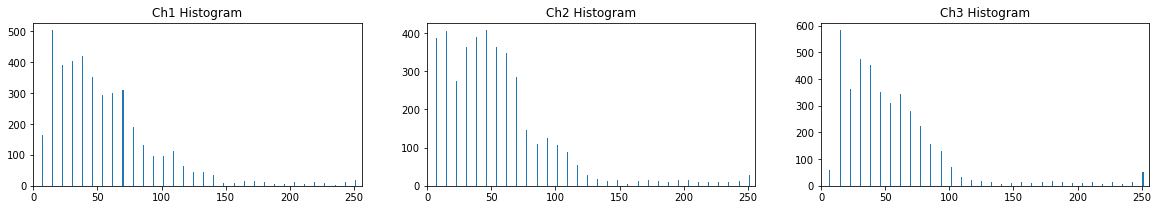

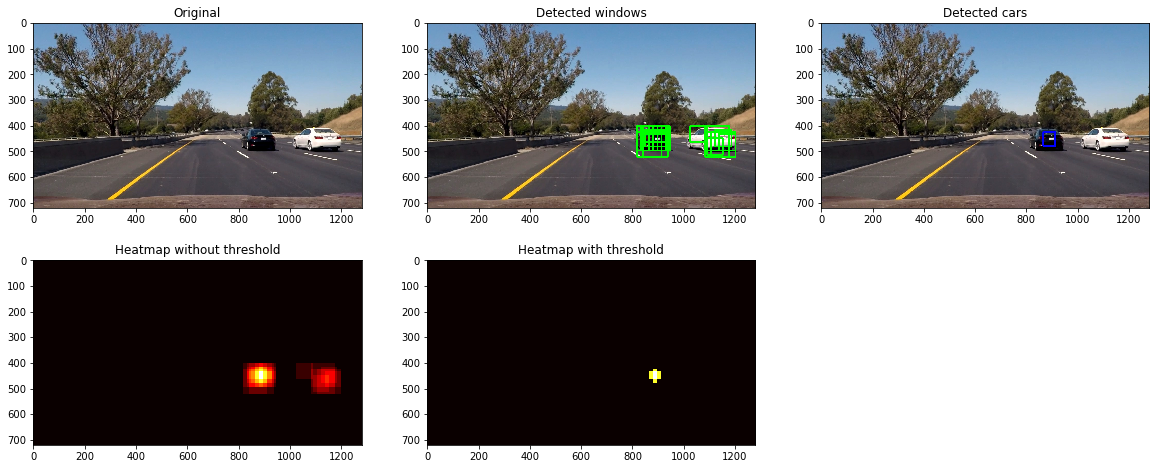

In [8]:
### Visualize the results

# Load training data images
images = glob.glob('./vehicles/KITTI_extracted/*.png')
rand_int = np.random.randint(0, len(images))
image = cv2.imread(images[rand_int])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get HOG image
YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
feat, hog_image = get_hog_features(YCrCb[:,:,0], orient, pix_per_cell, cells_per_block,
                                   vis=True, feature_vec=False)
# Display HOG image
fig = plt.figure(figsize=(17,4))
plt.subplot(131)
plt.imshow(image)
plt.title('Original RGB')
plt.subplot(132)
plt.imshow(YCrCb[:,:,0])
plt.title('Y Channel')
plt.subplot(133)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Get Color Histogram
ch1_hist = np.histogram(image[:,:,0], bins=hist_bins)
ch2_hist = np.histogram(image[:,:,1], bins=hist_bins)
ch3_hist = np.histogram(image[:,:,2], bins=hist_bins)
# Generate bin centers
bin_edges = ch1_hist[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
# Display Color Histogram
fig = plt.figure(figsize=(20,3))
plt.subplot(131)
plt.bar(bin_centers, ch1_hist[0])
plt.xlim(0, 256)
plt.title('Ch1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, ch2_hist[0])
plt.xlim(0, 256)
plt.title('Ch2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, ch3_hist[0])
plt.xlim(0, 256)
plt.title('Ch3 Histogram')

# Load an image on which to detect cars
image = cv2.imread('./test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
counter = 1
box_list, image_box = find_cars(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell,
                                cells_per_block, spatial_size, hist_bins, color_space, vis=True)

# Define a blank image on which to add 'heat'
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box_list
heat = add_heat(heat, box_list)
# Apply threshold to help remove false positives
heatmap = apply_threshold(heat, threshold)
# Clip any values outside of range
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
structure = np.ones((3,3))
labels = label(heatmap, structure=structure)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# Display detected cars
fig = plt.figure(figsize=(20,8))
plt.subplot(231)
plt.imshow(image)
plt.title('Original')
plt.subplot(232)
plt.imshow(image_box)
plt.title('Detected windows')
plt.subplot(233)
plt.imshow(draw_img)
plt.title('Detected cars')
plt.subplot(234)
plt.imshow(heat, cmap='hot')
plt.title('Heatmap without threshold')
plt.subplot(235)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap with threshold')